In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
!pip install pyarrow

In [15]:
df_single = pd.read_feather("timeseries_single_frequency.feather")
index_sampled_single=[]
values_sampled_single=[]
x_dat=[]
for i in range(0,1000):
    spl = interp1d(df_single.index, df_single[df_single.columns.values[i]].values, kind='nearest')
    x_new = np.linspace(min(df_single[df_single.columns.values[i]].values),max(df_single[df_single.columns.values[i]].values), 100)
    y_new = spl(df_single.index)
    index_sampled_single.append(y_new[:40])
    values_sampled_single.append(y_new[-10:])
    x_dat.append(x_new)
X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)

In [16]:
print(np.shape(index_sampled_single))

(1000, 40)


In [17]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=0.0001,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='linear') 
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=200,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/200
8/8 [==============================] - 0s 18ms/step - loss: 0.9379 - root_mean_squared_error: 0.9684 - val_loss: 0.7809 - val_root_mean_squared_error: 0.8837 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.7132 - root_mean_squared_error: 0.8445 - val_loss: 0.6518 - val_root_mean_squared_error: 0.8073 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.6111 - root_mean_squared_error: 0.7817 - val_loss: 0.5763 - val_root_mean_squared_error: 0.7592 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.5469 - root_mean_squared_error: 0.7396 - val_loss: 0.5223 - val_root_mean_squared_error: 0.7227 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4982 - root_mean_squared_error: 0.7058 - val_loss: 0.4815 - val_root_mean_squared_error: 0.6939 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 0s 5ms/step - loss: 0.4617 - root_mean

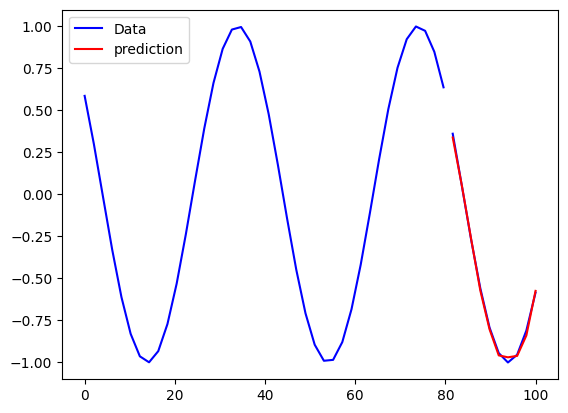

In [18]:
predictions = model.predict( tf.convert_to_tensor(X_test))

plt.plot(df_single.index[:40],X_test[0], color= 'blue', label='Data')
plt.plot(df_single.index[-10:],y_test[0], color= 'blue')
plt.plot(df_single.index[-10:],predictions[0], color= 'red', label ='prediction')
plt.legend()

In [6]:
df_single = pd.read_feather("timeseries_multiple_frequency.feather")
index_sampled_single=[]
values_sampled_single=[]

for i in range(0,1000):
    spl = interp1d(df_single.index, df_single[df_single.columns.values[i]].values, kind='nearest')
    x_new = np.linspace(min(df_single[df_single.columns.values[i]].values),max(df_single[df_single.columns.values[i]].values), 50)
    y_new = spl(df_single.index)
    index_sampled_single.append(y_new[:40])
    values_sampled_single.append(y_new[-10:])

X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)



In [21]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta= 1e-6,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-6,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='linear') 
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)


history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=200,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/200
8/8 [==============================] - 1s 22ms/step - loss: 0.7556 - root_mean_squared_error: 0.8693 - val_loss: 0.6280 - val_root_mean_squared_error: 0.7925 - lr: 0.0010
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.6282 - root_mean_squared_error: 0.7926 - val_loss: 0.5606 - val_root_mean_squared_error: 0.7487 - lr: 0.0010
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.5624 - root_mean_squared_error: 0.7499 - val_loss: 0.5167 - val_root_mean_squared_error: 0.7188 - lr: 0.0010
Epoch 4/200
8/8 [==============================] - 0s 6ms/step - loss: 0.5169 - root_mean_squared_error: 0.7189 - val_loss: 0.4860 - val_root_mean_squared_error: 0.6972 - lr: 0.0010
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.4837 - root_mean_squared_error: 0.6955 - val_loss: 0.4629 - val_root_mean_squared_error: 0.6804 - lr: 0.0010
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 0.4589 - root_mean

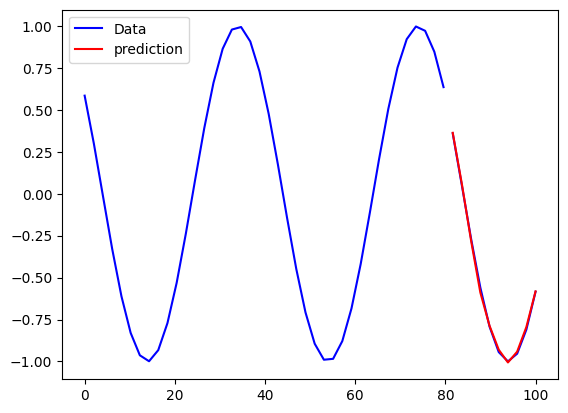

In [22]:
predictions = model.predict( tf.convert_to_tensor(X_test))

plt.plot(df_single.index[:40],X_test[0], color= 'blue', label='Data')
plt.plot(df_single.index[-10:],y_test[0], color= 'blue')
plt.plot(df_single.index[-10:],predictions[0], color= 'red', label ='prediction')
plt.legend()

In [87]:
df_single = pd.read_feather("timeseries_multiple_frequency_sampled.feather")
index_sampled_single=[]
values_sampled_single=[]

for i in range(0,1000):
    spl = interp1d(df_single[df_single.columns.values[i]].index, df_single[df_single.columns.values[i]].values, kind='nearest')
    y_new = spl(df_single[df_single.columns.values[i]].index)
    index_sampled_single.append(y_new[:40])
    values_sampled_single.append(y_new[-10:])

X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)



In [30]:
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

df_single = pd.read_feather("timeseries_multiple_frequency_sampled.feather")
index_sampled_single=[]
values_sampled_single=[]

for i in range(0,500):
    column_data = df_single.iloc[:, i]  
    clean_column_data = column_data.dropna()
    
    spl = interp1d(clean_column_data.index, clean_column_data.values, kind='nearest', fill_value="extrapolate")
    
    y_new = spl(np.linspace(np.min(clean_column_data.index),np.max(clean_column_data.index),50))

    index_sampled_single.append(y_new[:40])
    values_sampled_single.append(y_new[-10:])
    


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    index_sampled_single,values_sampled_single, test_size=0.05, random_state=0)


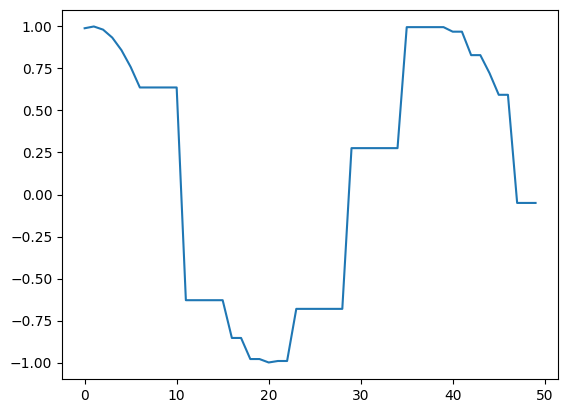

In [31]:
plt.plot(y_new)

In [35]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta= 1e-8,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-8,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='linear') 
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)


history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=500,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/500
4/4 [==============================] - 1s 44ms/step - loss: 1.0261 - root_mean_squared_error: 1.0129 - val_loss: 0.9370 - val_root_mean_squared_error: 0.9680 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 9ms/step - loss: 0.8805 - root_mean_squared_error: 0.9383 - val_loss: 0.8543 - val_root_mean_squared_error: 0.9243 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 0.7992 - root_mean_squared_error: 0.8940 - val_loss: 0.7981 - val_root_mean_squared_error: 0.8934 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 0.7414 - root_mean_squared_error: 0.8611 - val_loss: 0.7535 - val_root_mean_squared_error: 0.8680 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 0.6959 - root_mean_squared_error: 0.8342 - val_loss: 0.7170 - val_root_mean_squared_error: 0.8468 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 10ms/step - loss: 0.6586 - root_me

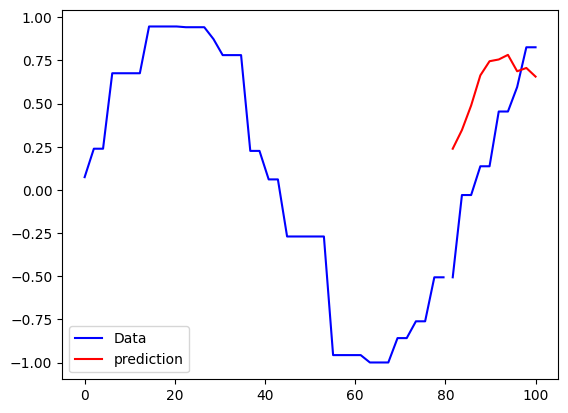

In [37]:
predictions = model.predict(tf.convert_to_tensor(X_test))

plt.plot(df_single.index[:40],X_test[4], color= 'blue', label='Data')
plt.plot(df_single.index[-10:],y_test[4], color= 'blue')
plt.plot(df_single.index[-10:],predictions[7], color= 'red', label ='prediction')
plt.legend()

In [24]:
index_sampled=[]
values_sampled=[]
x_dat=[]

plasticc_metadata = pd.read_pickle('plasticc_lightcurves_g_metadata.pkl')
with open('plasticc_lightcurves_g.pkl', 'rb') as file:
    plasticc_LC = pickle.load(file)

for i in range(0,1135):
    spl = interp1d(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index, plasticc_LC[plasticc_metadata['object_id'].iloc[i]].values, kind='cubic', fill_value= 'extrapolate')
    x_new = np.linspace(min(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index),max(plasticc_LC[plasticc_metadata['object_id'].iloc[i]].index), 50)
    y_new = spl(x_new)
    index_sampled.append(y_new[:40])
    values_sampled.append(y_new[-10:])
    x_dat.append(x_new)
X_train, X_test, y_train, y_test = train_test_split(index_sampled,values_sampled, test_size=0.05, random_state=0)



In [22]:
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

normalizer = layers.Normalization()
normalizer.adapt(X_train)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_root_mean_squared_error",
        factor=0.1,
        patience=5,
        verbose=1,
        min_delta=0.0001,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_root_mean_squared_error",
        min_delta=1e-4,
        patience=10,
        verbose=1,
    )
]
model = keras.Sequential([
    normalizer,
    layers.Dense(4, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(10, activation='linear') 
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

# Split data into training and validation sets
def split_dataset(data, labels, train_size=0.8):
    size = int(len(data) * train_size)
    train_data, train_labels = data[:size], labels[:size]
    val_data, val_labels = data[size:], labels[size:]
    return (train_data, train_labels), (val_data, val_labels)

# Apply the split function
(train_data, train_labels), (val_data, val_labels) = split_dataset(X_train, y_train)

# Train the model
history = model.fit(
    X_train, 
    y_train,
    batch_size=128,
    epochs=200,
    validation_data=(tf.convert_to_tensor(X_test), tf.convert_to_tensor(y_test)),
    callbacks=callbacks
)


Epoch 1/200
9/9 [==============================] - 1s 17ms/step - loss: 70418358272.0000 - root_mean_squared_error: 265364.5625 - val_loss: 24853610.0000 - val_root_mean_squared_error: 4985.3398 - lr: 0.0010
Epoch 2/200
9/9 [==============================] - 0s 5ms/step - loss: 70418366464.0000 - root_mean_squared_error: 265364.5625 - val_loss: 24853596.0000 - val_root_mean_squared_error: 4985.3379 - lr: 0.0010
Epoch 3/200
9/9 [==============================] - 0s 4ms/step - loss: 70418358272.0000 - root_mean_squared_error: 265364.5625 - val_loss: 24853572.0000 - val_root_mean_squared_error: 4985.3354 - lr: 0.0010
Epoch 4/200
9/9 [==============================] - 0s 5ms/step - loss: 70418333696.0000 - root_mean_squared_error: 265364.5312 - val_loss: 24853562.0000 - val_root_mean_squared_error: 4985.3345 - lr: 0.0010
Epoch 5/200
9/9 [==============================] - 0s 5ms/step - loss: 70418350080.0000 - root_mean_squared_error: 265364.5312 - val_loss: 24853540.0000 - val_root_mean_sq

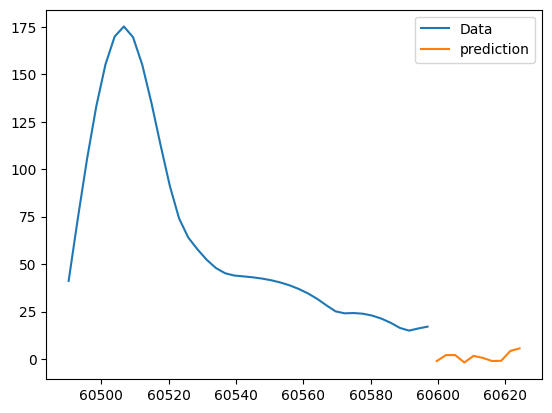

In [29]:
predictions = model.predict(val_data)

plt.plot(x_dat[2][:40], val_data[2], label='Data')
plt.plot(x_dat[2][-10:],predictions[2], label ='prediction')
plt.legend()